In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset
!unzip '/content/drive/MyDrive/Colab Notebooks/SKRIPSI/dataset.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/SKRIPSI/dataset.zip
  inflating: Modified_SQL_Dataset.csv  


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/SKRIPSI/code_paling_fix/demo_25_juni/sql_injection_bert_model.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/SKRIPSI/code_paling_fix/demo_25_juni/sql_injection_bert_model.zip
  inflating: sql_injection_bert_model/tokenizer_config.json  
  inflating: sql_injection_bert_model/vocab.txt  
  inflating: sql_injection_bert_model/config.json  
  inflating: sql_injection_bert_model/special_tokens_map.json  
  inflating: sql_injection_bert_model/tf_model.h5  


In [ ]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import urllib.parse
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download NLTK stopwords
nltk.download('stopwords')

# Load the dataset from the CSV file
df = pd.read_csv('/content/Modified_SQL_Dataset.csv')

# Drop any rows with missing values
df.dropna(inplace=True)

# Filter the dataset to only include rows with labels 0 or 1
df = df[(df['Label'] == 0) | (df['Label'] == 1)]

# Remove duplicate queries to avoid bias in training
df = df.drop_duplicates(subset='Query')

# Convert the 'Label' column to numeric type
df["Label"] = pd.to_numeric(df["Label"])

# Shuffle the dataset to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Rename columns for easier access
df.rename(columns={'Query': 'X', 'Label': 'y'}, inplace=True)

# Split the data into training, validation, and test sets (80%, 10%, 10%)
slice_index_1 = int(0.8 * len(df))
slice_index_2 = int(0.9 * len(df))
train_df = df.iloc[:slice_index_1, :]
val_df = df.iloc[slice_index_1:slice_index_2, :]
test_df = df.iloc[slice_index_2:, :]

# Separate features (queries) and labels for each set
X_train = train_df['X']
y_train = train_df['y']
X_val = val_df['X']
y_val = val_df['y']
X_test = test_df['X']
y_test = test_df['y']

# Load the BERT model and tokenizer from Google Drive
model_load_path = '/content/sql_injection_bert_model'
tokenizer = BertTokenizer.from_pretrained(model_load_path)
model = TFBertForSequenceClassification.from_pretrained(model_load_path)

# Function to convert data to BERT input format
def convert_data_to_examples(X, y):
    examples = []
    for i in range(len(X)):
        examples.append(InputExample(guid=None, text_a=X.iloc[i], text_b=None, label=y.iloc[i]))
    return examples

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )
        input_ids, attention_mask = input_dict['input_ids'], input_dict['attention_mask']
        features.append(
            InputFeatures(input_ids=input_ids, attention_mask=attention_mask, label=e.label)
        )

    def gen():
        for f in features:
            yield (
                {
                    'input_ids': f.input_ids,
                    'attention_mask': f.attention_mask
                },
                f.label
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({
            'input_ids': tf.int32,
            'attention_mask': tf.int32
        },
        tf.int64),
        ({
            'input_ids': tf.TensorShape([None]),
            'attention_mask': tf.TensorShape([None])
        },
        tf.TensorShape([]))
    )

# Convert data to BERT input format
train_examples = convert_data_to_examples(X_train, y_train)
val_examples = convert_data_to_examples(X_val, y_val)
test_examples = convert_data_to_examples(X_test, y_test)

# Convert examples to TensorFlow datasets
train_ds = convert_examples_to_tf_dataset(train_examples, tokenizer)
val_ds = convert_examples_to_tf_dataset(val_examples, tokenizer)
test_ds = convert_examples_to_tf_dataset(test_examples, tokenizer)

batch_size = 32
train_ds = train_ds.shuffle(buffer_size=1024, seed=42).batch(batch_size).repeat()
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Display the model architecture
model.summary()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Some layers from the model checkpoint at /content/sql_injection_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/sql_injection_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBert

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


97/97 [==============================] - 46s 258ms/step

Confusion Matrix:
[[1978    0]
 [   5 1108]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9975    1.0000    0.9987      1978
           1     1.0000    0.9955    0.9977      1113

    accuracy                         0.9984      3091
   macro avg     0.9987    0.9978    0.9982      3091
weighted avg     0.9984    0.9984    0.9984      3091



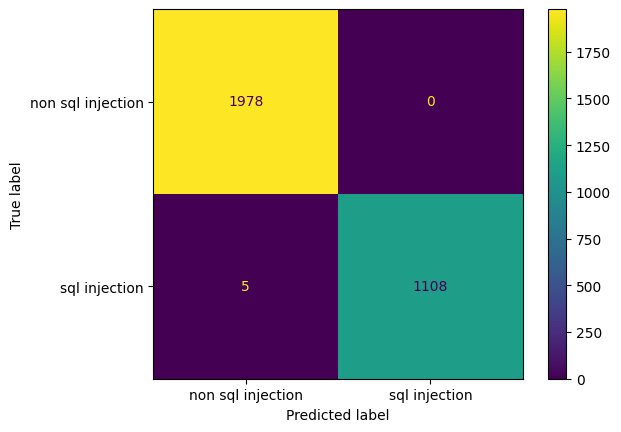

In [ ]:
# Clear any previous confusion_matrix variable
# if 'confusion_matrix' in locals():
#     del confusion_matrix

# Predict the labels for the test set
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob.logits > 0.5).astype("int32")

# Print the confusion matrix and classification report for the test set
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Generate and display the confusion matrix plot
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non sql injection', 'sql injection'])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'accuracy score  : {accuracy_score(y_test, y_pred)}')
print(f'precision score : {precision_score(y_test, y_pred)}')
print(f'recall score    : {recall_score(y_test, y_pred)}')
print(f'f1 score        : {f1_score(y_test, y_pred)}')

accuracy score  : 0.9983824005176318
precision score : 1.0
recall score    : 0.995507637017071
f1 score        : 0.9977487618190005


In [ ]:
# Function to predict if an input query is an SQL injection statement
def predict_sql_injection(query):
    # Tokenize the query using the trained tokenizer
    inputs = tokenizer(query, return_tensors='tf', max_length=128, padding='max_length', truncation=True)

    # Predict using the trained model
    prediction_prob = model.predict(inputs)
    prediction = (prediction_prob.logits > 0.5).astype("int32")

    # Print the prediction result
    if prediction == 1:
        print("\nTHE INPUT IS AN SQL INJECTION.\n")
    else:
        print("\nTHE INPUT IS NOT AN SQL INJECTION.\n")

# Function to extract the query string from a web request
def extract_query_string(web_request):
    # Split the request into parts
    parts = web_request.split()

    # Get the part containing the URL
    url_part = parts[6]

    # Split the URL into components
    parsed_url = urllib.parse.urlparse(url_part)

    # Extract and decode the query string
    encoded_query_string = parsed_url.query
    decoded_query_string = urllib.parse.unquote(encoded_query_string)

    # Remove the '+' sign and print the decoded query string
    decoded_query_string = decoded_query_string.replace('+', ' ')
    print(f'\nquery string: {decoded_query_string}\n')

    # Predict if the query string is an SQL injection
    return predict_sql_injection(decoded_query_string)

In [ ]:
# Main loop to get user input and predict SQL injection
while True:
    user_input = input("Enter a query to check if it's an SQL injection (or type 'exit' to quit):")
    if user_input.lower() == 'exit':
        break
    extract_query_string(user_input)

Enter a query to check if it's an SQL injection (or type 'exit' to quit):::1 - - [25/Jun/2024:21:37:47 +0700] "GET /dvwa/vulnerabilities/sqli/?id=%27+UNION+SELECT+user%2C+password+FROM+users+--&Submit=Submit&user_token=82c907425c04c059ebc4a4ced3237078 HTTP/1.1" 200 4313 "http://localhost/dvwa/vulnerabilities/sqli/" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"
